# 🎮 Pokémon Data & Analytics Platform

## Objective
Build a modern data engineering pipeline that extracts rich Pokémon data from the [PokeAPI](https://pokeapi.co/), processes and stores it in a scalable **Lakehouse architecture**, and enables complex analytical queries, ML insights, and interactive visualizations.

## Key Features / Workflow

### 1. Data Ingestion (ELT Pipeline)
- Periodically extract data from the PokeAPI.
- Extract hierarchical data:
  - Pokémon → Evolutions → Moves → Stats → Types.
- Store raw JSON data in a **data lake** (e.g., AWS S3, GCS, or local MinIO) or SQLite

In [ ]:
import requests

# Refer to ditto_example.json for sample Pokemon response structure.

url = "https://pokeapi.co/api/v2/pokemon?limit=100"
response = requests.get(url, verify=False) # Self-signed SSL certificate error, so I disabled verification for development purposes
pokemon_list = response.json()['results'] # Response returns a list of Pokemon, not individual Pokemon

full_pokemon_data = []
for pokemon in pokemon_list:
    poke_response = requests.get(pokemon['url'], verify=False) # Second request using url from the list of Pokemon
    full_pokemon_data.append(poke_response.json())

### 2. Data Transformation
- Use **Apache Spark** (PySpark) for transformation:
  - Flatten and normalize nested structures.
  - Create dimensional models:
    - `pokemon` (fact)
    - `types`, `abilities`, `moves` (dimensions)
  - Enrich data with external datasets (e.g., popularity, games, community rankings).

In [ ]:
import pandas as pd
import sqlite3

conn = sqlite3.connect('pokedex.db')

def extract_ability_names(abilities):
    return ", ".join([a['ability']['name'] for a in abilities])

def extract_type_names(types):
    return ", ".join([t['type']['name'] for t in types])

def extract_move_names(moves):
    return ", ".join([m['move']['name'] for m in moves])

if full_pokemon_data:
    df = pd.json_normalize(full_pokemon_data)
    columns_to_keep = ['name', 'height', 'weight', 'abilities', 'types', 'moves']
    df = df[columns_to_keep]

    df['abilities'] = df['abilities'].apply(extract_ability_names)
    df['types'] = df['types'].apply(extract_type_names)
    df['moves'] = df['moves'].apply(extract_move_names)
    
    df.to_sql('pokemon', conn, if_exists='replace', index=False)
    df_loaded = pd.read_sql('SELECT * FROM pokemon', conn)
    display(df_loaded)
    
    conn.close()

,name,height,weight,abilities,types,moves
0,bulbasaur,7,69,"overgrow, chlorophyll","grass, poison","razor-wind, swords-dance, cut, bind, vine-whip..."
1,ivysaur,10,130,"overgrow, chlorophyll","grass, poison","swords-dance, cut, bind, vine-whip, headbutt, ..."
2,venusaur,20,1000,"overgrow, chlorophyll","grass, poison","swords-dance, cut, bind, vine-whip, headbutt, ..."
3,charmander,6,85,"blaze, solar-power",fire,"mega-punch, fire-punch, thunder-punch, scratch..."
4,charmeleon,11,190,"blaze, solar-power",fire,"mega-punch, fire-punch, thunder-punch, scratch..."
...,...,...,...,...,...,...
95,drowzee,10,324,"insomnia, forewarn, inner-focus",psychic,"pound, mega-punch, fire-punch, ice-punch, thun..."
96,hypno,16,756,"insomnia, forewarn, inner-focus",psychic,"pound, mega-punch, fire-punch, ice-punch, thun..."
97,krabby,4,65,"hyper-cutter, shell-armor, sheer-force",water,"vice-grip, guillotine, swords-dance, cut, slam..."
98,kingler,13,600,"hyper-cutter, shell-armor, sheer-force",water,"vice-grip, guillotine, swords-dance, cut, slam..."


,name,height,weight,types
0,bulbasaur,7,69,"grass, poison"
1,ivysaur,10,130,"grass, poison"
2,venusaur,20,1000,"grass, poison"
3,charmander,6,85,fire
4,charmeleon,11,190,fire
...,...,...,...,...
95,drowzee,10,324,psychic
96,hypno,16,756,psychic
97,krabby,4,65,water
98,kingler,13,600,water


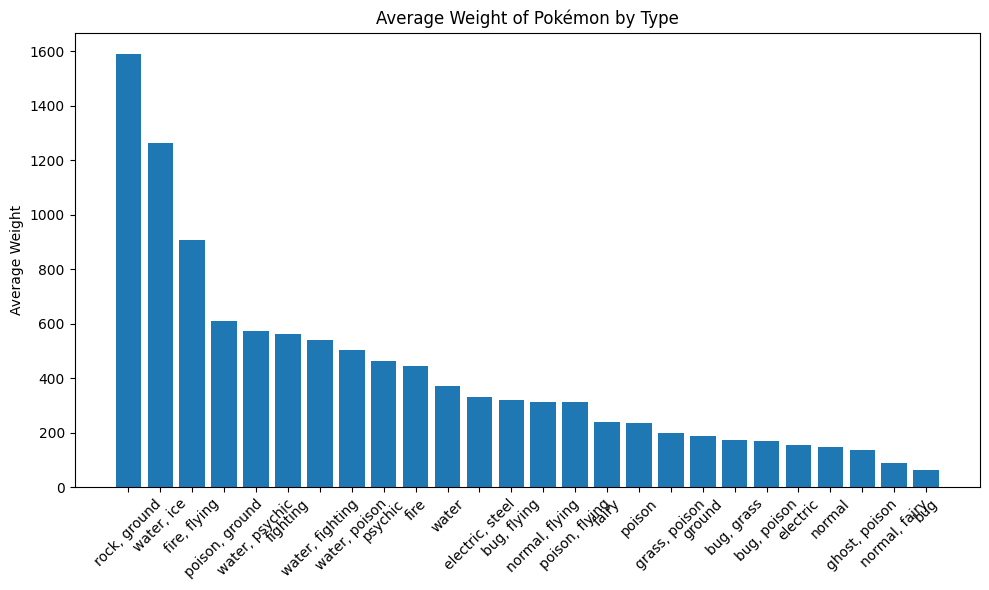

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sqlite3

conn = sqlite3.connect('pokedex.db')

query = """
SELECT name, height, weight, types
FROM pokemon
"""
df = pd.read_sql(query, conn)

# I will need to split the 'types' column
avg_weight = df.groupby('types', as_index=False)['weight'].mean().rename(columns={'weight': 'avg_weight'}).sort_values('avg_weight', ascending=False)
display(df)

conn.close()

plt.figure(figsize=(10, 6))
plt.bar(avg_weight['types'], avg_weight['avg_weight'])
plt.xticks(rotation=45)
plt.ylabel('Average Weight')
plt.title('Average Weight of Pokémon by Type')
plt.tight_layout()
plt.show()

### 3. Data Storage (Lakehouse Architecture)
- Store processed data

### 4. Data Serving & Exploration
- Use tools like:
  - **Apache Superset** / **Metabase** / **Streamlit**
- Build visualizations and dashboards:
  - Top 10 strongest Pokémon by base stats.
  - Evolution treemaps.
  - Type effectiveness matrix.
  - Fun stats and comparisons.
- Interactive querying:
  - E.g., "List all Fire-type Pokémon with speed > 100 and special attack > 90".

### 5. Machine Learning & Graph Analytics (Bonus)
- **Clustering**: Use K-Means to group similar Pokémon based on stats.
- **Classification**: Predict battle outcomes using logistic regression or tree-based models.
- **Graph Analysis**:
  - Use **NetworkX** or **Neo4j** to explore evolution chains as directed graphs.

## Bonus Ideas
- **API Gateway**:
  - Build a FastAPI or GraphQL service layer on top of your Lakehouse data.
- **Streaming**:
  - Simulate real-time "wild Pokémon encounters" using **Kafka** + **Spark Structured Streaming**.
- **Leaderboard**:
  - Create a dynamic ranking of strongest Pokémon by an aggregated score (e.g., sum of normalized stats).
- **Data Versioning**:
  - Integrate **DVC** or **LakeFS** to version data and track evolution of your datasets over time.